### Loading Data and Packages

In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib as plt
import numpy as np
import sqlite3
import datetime
import matplotlib.pyplot as pyplot
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes import GammaGammaFitter

import seaborn as sns

In [2]:
#Import Data
tx_data=pd.read_csv("UCI_online/data.csv")
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
# Establish connection with internal db
con = sqlite3.connect('UCI.db')
cursor = con.cursor()
# Drop tables that already exist by running the following commands
cursor.executescript("DROP TABLE IF EXISTS transactions")

In [4]:
# import data to db
tx_data.to_sql('transactions', con, if_exists="replace")

## Outline

**Exploratory Data Analysis**
1. How transactions vary with time.
2. The customer distribution of different frequencies.
2. Contribution in revenue from first-time and repeat purchases.

**Data Preprocessing and Fitting BG/NBD Model**
1. Splitting data into calibration and holdout period.
2. Fitting BG-NBD model using lifetimes package.
3. Estimating holdout frequency and "alive" probability.

**Assessing BG/NDB Model**
1. Recovering data (Simulation) from model parameters to verify correct model specification.
2. Visualization of model prediction vs. actual holdout frequency
3. Calculating average errors for each cohort of customers.

**Estimating Customer Lifetime Value (CLTV) Using the Gamma-Gamma Model**
1. Verifying the independence (between monetary value and frequency) assumption.
2. Estimating transaction value for each customer.
3. Computing total CLTV using DCF Method.
4. Analyzing Features of Customers with Highest CLTV.

**Assessing our CLTV Model**
1. Predicting the customer value for the next 100 days (Holdout-Period)
2. Comparing with the actual holdout total value and computing MSE.
3. Examining model correctness by visualizing the distribution of customer value.

**Demonstrating Model Application with Further Analysis**
1. Looking for correlation between frequency, monetary value and customer lifetime value.
2. Show the benefit of targeting "dying" customers with email marketing/coupon.

###  Exploratory Data Analysis 

Some basic analysis from the transaction dataset.
1. How transactions vary with time.
2. The customer distribution of different frequencies.
3. Contribution in revenue from first-time and repeat purchases.

In [5]:
# Number of unique for each column
tx_data.nunique(axis=0)

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

#### We want to look at the trend of number of transactions and the total amount in value over all dates.

In [6]:
# Make a copy of the original dataset.
tx_keep_date = tx_data.copy()
    
# Extract date from datetime
tx_keep_date['InvoiceDate'] = pd.to_datetime(tx_keep_date['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date

# days from first date
tx_keep_date['days_from_first'] = (tx_keep_date['InvoiceDate'] - tx_keep_date['InvoiceDate'].min()).dt.days

# Into database
tx_keep_date.to_sql("tx_keep_date", con, if_exists="replace")

In [7]:
sql1 = """
SELECT days_from_first, SUM(Quantity*UnitPrice) AS value, COUNT(*) AS orders 
FROM tx_keep_date
GROUP BY days_from_first
ORDER BY days_from_first
"""
sql1_df = pd.read_sql(sql1, con)

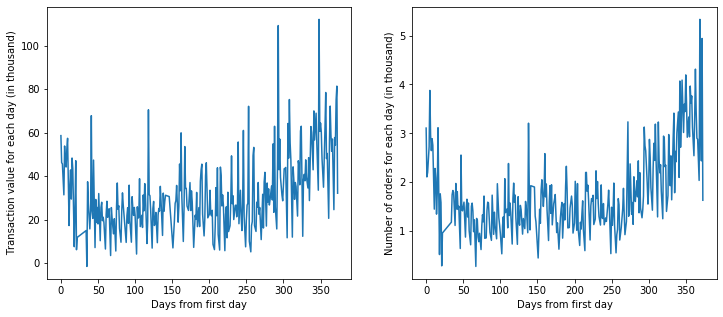

In [8]:
days_from_first = np.array(sql1_df['days_from_first'])
value_each_day = np.array(sql1_df['value'])
orders_each_day = np.array(sql1_df['orders'])
assert len(days_from_first)==len(value_each_day)==len(orders_each_day)

pyplot.figure(figsize=(12, 5))
pyplot.subplot(121)
pyplot.plot(days_from_first, value_each_day/1000)
pyplot.xlabel("Days from first day")
pyplot.ylabel("Transaction value for each day (in thousand)")
pyplot.subplot(122)
pyplot.plot(days_from_first, orders_each_day/1000)
pyplot.xlabel("Days from first day")
pyplot.ylabel("Number of orders for each day (in thousand)")
pyplot.show()

There is an obvious upward trend in October, November 2011. Our estimate for the holdout period might be underestimating the money value and frecuency with our model.

#### We aggregate transaction data by customerID. We are particularly interested in the distribution of the frequncy of customers. Most of them make repeat purchases. 

In [9]:
sql2 = """
SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value, 
SUM(Quantity*UnitPrice)/COUNT(*) AS money_value, COUNT(*) AS frequency
FROM transactions
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID 
HAVING COUNT(*) > 0 AND total_value > 0
ORDER BY COUNT(*) DESC
"""
sql2_df = pd.read_sql(sql2, con)
sql2_df.head(n=10)

,CustomerID,total_value,money_value,frequency
0,17841.0,40340.78,5.053336,7983
1,14911.0,132572.62,22.458516,5903
2,14096.0,57120.91,11.139023,5128
3,12748.0,29072.10,6.262839,4642
4,14606.0,11713.85,4.210586,2782
5,15311.0,59419.34,23.853609,2491
6,14646.0,279489.02,134.047492,2085
7,13089.0,57385.88,30.902466,1857
8,13263.0,7454.07,4.444884,1677
9,14298.0,50862.44,31.013683,1640


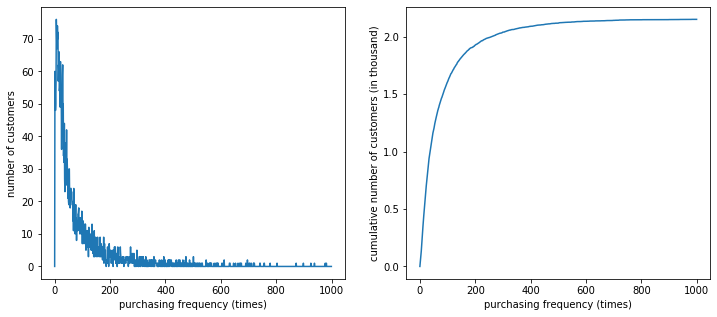

In [10]:
# the distribution of # of transactions per customer (<1000)
customer_times_vector = np.array(sql2_df['frequency'])
count_vector = [np.sum(customer_times_vector==i) for i in range(8000)]

pyplot.figure(figsize=(12, 5))
pyplot.subplot(121)
pyplot.plot(range(1000), count_vector[:1000])
pyplot.xlabel("purchasing frequency (times)")
pyplot.ylabel("number of customers")
pyplot.subplot(122)
pyplot.plot(range(1000), np.cumsum(count_vector)[:1000]/2000)
pyplot.xlabel("purchasing frequency (times)")
pyplot.ylabel("cumulative number of customers (in thousand)")
pyplot.show()

#### We wanted to show that repeat purchase is large portion of revenue.

In [11]:
sql2_df.to_sql('tx_customer',con,if_exists = "replace")

In [12]:
def total_value_with_n_tx(n=1):
    sql3 = f"""
    SELECT SUM(total_value) AS total FROM tx_customer 
    GROUP BY frequency
    HAVING frequency = {n}
    """
    sql3_df = pd.read_sql(sql3, con)
    if sql3_df.shape[0] != 0:
        return sql3_df.iloc[0]['total']
    else: 
        return 0

In [13]:
total_by_frequency = []
for n in range(200):
    total_by_frequency.append(total_value_with_n_tx(n+1))
first_by_frequency = np.array(total_by_frequency)/list(range(1,201))

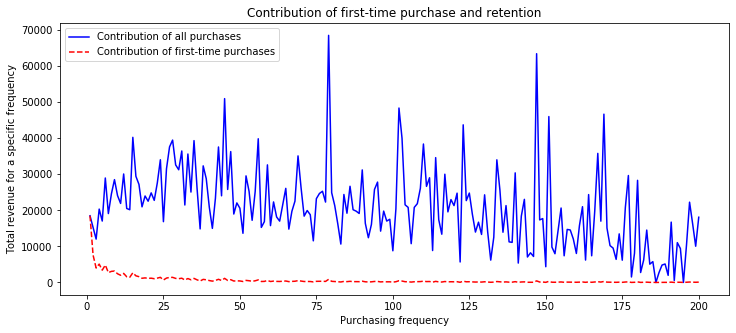

In [14]:
pyplot.figure(figsize=(12, 5))
pyplot.plot(range(1,201), total_by_frequency, 'b', label="Contribution of all purchases")
pyplot.plot(range(1,201), first_by_frequency,'r--', label="Contribution of first-time purchases")
pyplot.xlabel('Purchasing frequency')
pyplot.ylabel('Total revenue for a specific frequency')
pyplot.title('Contribution of first-time purchase and retention')
pyplot.legend(loc="upper left")

For all models, the following nomenclature is used:

• frequency represents the number of repeat purchases the customer has made. This means that it’s one less
than the total number of purchases. This is actually slightly wrong. <span style="color:red"> It’s the count of time periods the customer had a purchase in</span>. So if using days as units, then it’s the count of days the customer had a purchase on.

• T represents the age of the customer in whatever time units chosen (daily, for our dataset). This is equal
to the duration between a customer’s first purchase and the end of the period under study.

• recency represents the age of the customer when they made their most recent purchases. This is equal to the
duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase,
the recency is 0.)

• monetary_value represents the average value of a given customer’s purchases. This is equal to the sum of
all a customer’s purchases divided by the total number of purchases. <span style="color:red">Note that the denominator here is different than the frequency described above</span>.

### Data Prepocessing and BG/NBD model
An important note: <span style="color:red">Calibration period ends 2011-08-31 (default, can be changed below).</span>

Then we fit the BG/NBD model on the processed data to obatin the parameter estimate $r$, $\alpha$, $a$ and $b$.

In [15]:
def all_customers(original_data_frame = None) -> pd:
    """
    takes the original csv dataset read
    leaves out transactions with negative amount
    
    returns a pandas dataframe that contains the following columns:
    CustomerID, total_value, latest_purchase_date, first_purchase_date, monetary_value_per_purchase, frequecy_day
    """
    # Make a copy of the original dataset.
    tx_keep_date = tx_data.copy()
    # Extract date from datetime
    tx_keep_date['InvoiceDate'] = pd.to_datetime(tx_keep_date['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date
    # Import the training data into db
    tx_keep_date.to_sql("tx_keep_date", con=con, if_exists="replace")
    sql = """
    SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value, 
    MAX(InvoiceDate) AS latest, MIN(InvoiceDate) AS first, 
    SUM(Quantity*UnitPrice)/COUNT(*) AS monetary_value, CASE WHEN COUNT(DISTINCT InvoiceDate)-1 < 0 THEN 0 ELSE COUNT(DISTINCT InvoiceDate)-1 END AS frequency
    FROM tx_keep_date
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID 
    HAVING COUNT(DISTINCT InvoiceDate) >= 0 AND total_value >= 0
    ORDER BY COUNT(DISTINCT InvoiceDate) DESC
    """
    all_customers_df = pd.read_sql(sql, con)
    return all_customers_df

In [16]:
def cal_holdout(original_data_frame = None, cal_end_date = "2011-08-31") -> pd:
    """
    takes the original csv dataset read and the last day of calibration period.
    leaves out transactions with negative amount
    
    
    returns a pandas dataframe with columns:
    
    CustomerID (primary index),
    total_value_cal (total value of this customer during the calibration period, 0 if no purchase),
    first_within_cal (date of first purchase in the calibration period),
    latest_within_cal (date of latest purchase in the calibration period),
    monetary_value_cal (average value of each transaction in the calibration period, 0 if no purchase),
    frequency_cal (number of repeat purchase in the calibration period),
    recency_cal (time interval in days from the last purchase to the first),
    T_cal (time interval in days from the end of cal period to the first purchase),
    frequency_holdout (number of repeat purchase in the holdout period),
    total_value_holdout (total value of this customer in the holdout period, 0 if no purchase),
    monetary_value_holdout (average value of each transaction in the holdout period, 0 if no purchase),
    duration_holdout (duration in days of holdout period)
    """
    # Make a copy of the original dataset.
    tx_keep_date = tx_data.copy()
    
    # Extract date from datetime
    tx_keep_date['InvoiceDate'] = pd.to_datetime(tx_keep_date['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date
    
    # Extract all the records whose transaction date is within calibration period.
    cal_df = tx_keep_date[tx_keep_date['InvoiceDate'] <= datetime.date.fromisoformat(cal_end_date)]
    # The rest as holdout
    hold_df = tx_keep_date[tx_keep_date['InvoiceDate'] > datetime.date.fromisoformat(cal_end_date)]
    
    # Use the latest record in holdout to calculate duration_holdout
    latest_holdout = hold_df['InvoiceDate'].max()
    duration_holdout = (latest_holdout - datetime.date.fromisoformat(cal_end_date)).days
    
    # Export pandas df to db
    cal_df.to_sql("cal", con, if_exists="replace")
    hold_df.to_sql("hold", con, if_exists="replace")
    
    sql = f"""
    SELECT c.CustomerID, c.total_value_cal, c.first_within_cal, c.latest_within_cal, 
    c.monetary_value_cal, c.frequency_cal, julianday(c.latest_within_cal)-julianday(c.first_within_cal) AS recency_cal,
    julianday('{cal_end_date}')-julianday(c.first_within_cal) AS T_cal,
    IFNULL(h.frequency_hold, 0) AS frequency_holdout, IFNULL(h.total_value_hold, 0) AS total_value_holdout, 
    IFNULL(h.monetary_value_hold, 0) AS monetary_value_holdout, {duration_holdout} AS duration_holdout
    FROM
    (SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value_cal, 
    MAX(InvoiceDate) AS latest_within_cal, MIN(InvoiceDate) AS first_within_cal, 
    SUM(Quantity*UnitPrice)/COUNT(*) AS monetary_value_cal, 
    CASE WHEN COUNT(DISTINCT InvoiceDate)-1 < 0 THEN 0 ELSE COUNT(DISTINCT InvoiceDate)-1 END AS frequency_cal
    FROM cal
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID 
    HAVING COUNT(DISTINCT InvoiceDate) >= 0 AND total_value_cal >= 0) c
    LEFT JOIN 
    (SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value_hold,
    SUM(Quantity*UnitPrice)/COUNT(*) AS monetary_value_hold, 
    COUNT(DISTINCT InvoiceDate) AS frequency_hold
    FROM hold
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID
    HAVING COUNT(DISTINCT InvoiceDate) >= 0 AND total_value_hold >= 0) h
    ON c.CustomerID = h.CustomerID
    ORDER BY c.CustomerID
    
    """
    cal_hold_df = pd.read_sql(sql, con)
    cal_hold_df.set_index('CustomerID', inplace=True, drop=True)
    return cal_hold_df

In [17]:
# Using self-defined cal_holdout function
cal_hold_df = cal_holdout(tx_data)
cal_hold_df.head()

,total_value_cal,first_within_cal,latest_within_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,,,,,
12346.0,0.00,2011-01-18,2011-01-18,0.000000,0,0.0,225.0,0,0.00,0.000000,100
12347.0,2790.86,2010-12-07,2011-08-02,22.506935,4,238.0,267.0,2,1519.14,26.192069,100
12348.0,1487.24,2010-12-16,2011-04-05,53.115714,2,110.0,258.0,1,310.00,103.333333,100
12350.0,334.40,2011-02-02,2011-02-02,19.670588,0,0.0,210.0,0,0.00,0.000000,100
12352.0,601.18,2011-02-16,2011-03-22,12.524583,3,34.0,196.0,3,944.23,20.090000,100


In [18]:
# look for anomalies
cal_hold_df[((cal_hold_df['monetary_value_cal']<=0) & (cal_hold_df['frequency_cal']>0))]

,total_value_cal,first_within_cal,latest_within_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,,,,,
17190.0,0.0,2011-05-16,2011-06-06,0.0,1,21.0,107.0,1,249.74,13.874444,100


In [19]:
# drop customer id == 17190.0
cal_hold_df.drop(17190.0).head()

,total_value_cal,first_within_cal,latest_within_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,,,,,
12346.0,0.00,2011-01-18,2011-01-18,0.000000,0,0.0,225.0,0,0.00,0.000000,100
12347.0,2790.86,2010-12-07,2011-08-02,22.506935,4,238.0,267.0,2,1519.14,26.192069,100
12348.0,1487.24,2010-12-16,2011-04-05,53.115714,2,110.0,258.0,1,310.00,103.333333,100
12350.0,334.40,2011-02-02,2011-02-02,19.670588,0,0.0,210.0,0,0.00,0.000000,100
12352.0,601.18,2011-02-16,2011-03-22,12.524583,3,34.0,196.0,3,944.23,20.090000,100


In [20]:
bgf1 = BetaGeoFitter(penalizer_coef=0.01)
bgf1.fit(cal_hold_df['frequency_cal'], cal_hold_df['recency_cal'], cal_hold_df['T_cal'])
bgf1.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.731398,0.026519,0.679420,0.783376
alpha,49.280975,2.245855,44.879099,53.682851
a,0.025031,0.006795,0.011712,0.038350
b,0.310906,0.074960,0.163984,0.457829




### Using the Frequency/Recency matrix to look at the expected number of transactions a customer is to make in the next time period (in our case, the next day)

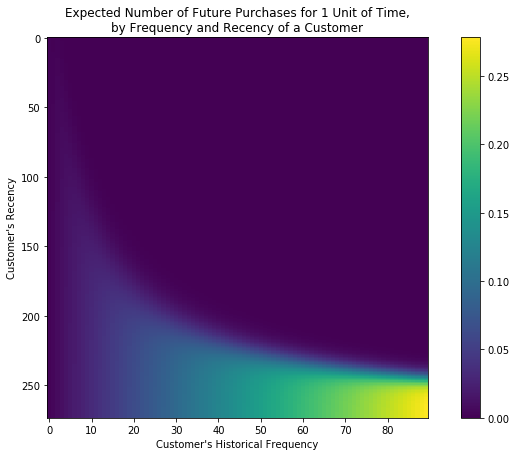

In [23]:
# Frequency/Recency Matrix - the expected number of transactions a customer is to make in the next time period

pyplot.figure(figsize=(12, 7))
plot_frequency_recency_matrix(bgf1)
pyplot.show()


The “warm” zone in the bottom-right corner represents the most reliable and committed customers, who purchase frequency and placed their latest order recently.

Older and less frequent (“colder”) customers are shown in the top left.

A tail is visible in the bottom-left quadrant. These customers are infrequent but made a purchase recently, so the model expects them to make more purchases in the near future.

### Using the Frequency/Recency matrix to look at the probability of a customer still being "alive".

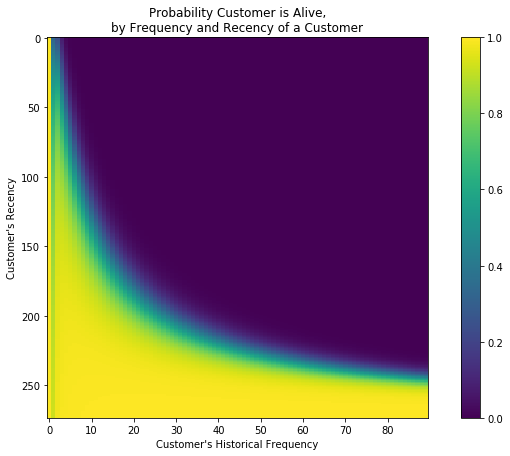

In [24]:
# Frequency/Recency Matrix - the probability of still being "alive"

pyplot.figure(figsize=(12, 7))
plot_probability_alive_matrix(bgf1)
pyplot.show()

Customers who purchased recently are more likely to be "alive".

### Take a look at our best customers
based on expected number of purchases

In [25]:
# create a subset of cal_hold_df 
cal_df = cal_hold_df[['frequency_cal', 'recency_cal', 'T_cal']]

# time period
t = 1

# top n customers
top_n = 10

# sort customers by expected number of purchases in the next t days and display the top n customers
cal_df['predicted_purchases'] = bgf1.conditional_expected_number_of_purchases_up_to_time(t, 
                                cal_df['frequency_cal'], cal_df['recency_cal'], cal_df['T_cal'])
cal_df.sort_values(by='predicted_purchases').tail(top_n)

,frequency_cal,recency_cal,T_cal,predicted_purchases
CustomerID,,,,
15189.0,33,226.0,232.0,0.119723
14527.0,43,272.0,273.0,0.135596
12971.0,50,265.0,272.0,0.157653
16422.0,53,269.0,269.0,0.168730
15311.0,62,261.0,273.0,0.193785
13089.0,61,269.0,269.0,0.193864
14606.0,64,270.0,273.0,0.200701
12748.0,69,272.0,273.0,0.216261
17841.0,73,270.0,273.0,0.228613


### Look at the historical probability of being alive of a customer

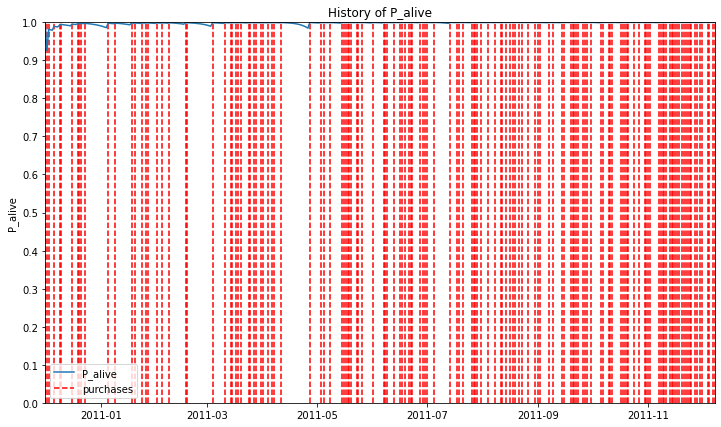

In [25]:
# let's look at our best customer
id = 14911.0
days_since_birth = 365
sp_trans = tx_keep_date.loc[tx_keep_date['CustomerID'] == id]

pyplot.figure(figsize=(12, 7))
plot_history_alive(bgf1, days_since_birth, sp_trans, 'InvoiceDate')
pyplot.show()

The red dashed line means a purchase has been made. The blue curve means the probability of being alive over time.

### Assessing model fit (frequency)
compare our data vs. simulated data with our fitted model's parameters

<Figure size 864x504 with 0 Axes>

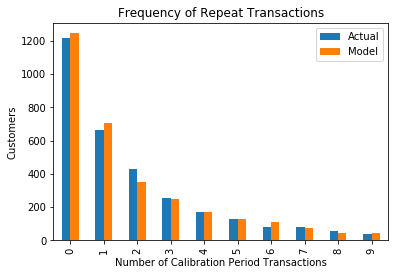

In [26]:
pyplot.figure(figsize=(12, 7))
p = plot_period_transactions(bgf1, max_frequency = 10)
pyplot.show()

/Users/daiyangli/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


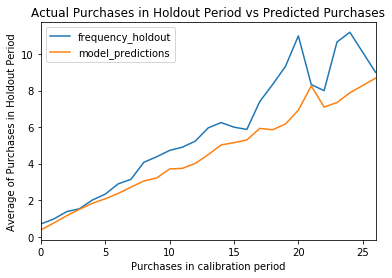

In [28]:
# create a subset of cal_hold_df
cal_hold_df_summary = cal_hold_df[['frequency_cal', 'recency_cal', 'T_cal', 'frequency_holdout', 'duration_holdout' ]]

bgf1.fit(cal_hold_df_summary['frequency_cal'], cal_hold_df_summary['recency_cal'], cal_hold_df_summary['T_cal'])

cal_hold_plot = plot_calibration_purchases_vs_holdout_purchases(bgf1, cal_hold_df_summary, n=26)

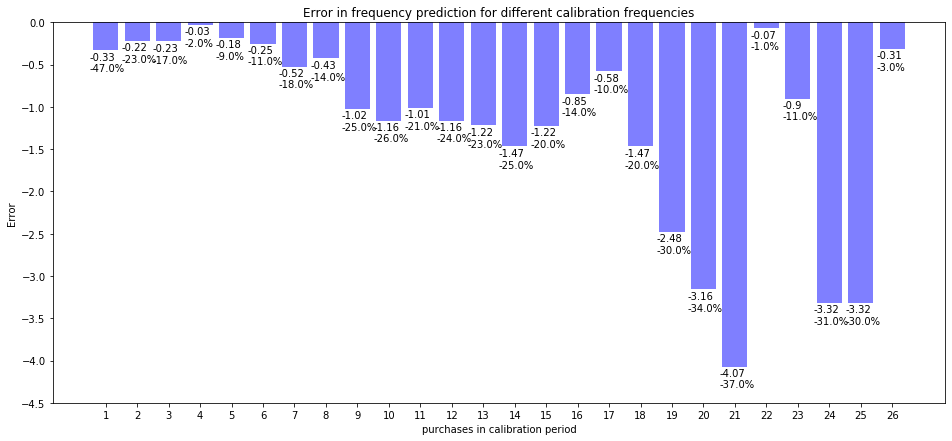

In [29]:
x_dat = cal_hold_plot.lines[0].get_xdata()
y_dat_actu = cal_hold_plot.lines[0].get_ydata()
y_dat_pred = cal_hold_plot.lines[1].get_ydata()
diff_ = y_dat_pred - y_dat_actu
diff_2d  = list(np.around(np.array(diff_),2))

fig, ax = pyplot.subplots()
fig.set_figheight(7)
fig.set_figwidth(16)
y_pos = np.arange(len(diff_))
ax.bar(y_pos, diff_, align="center", color="blue", alpha=0.5)
ax.set_ylim([-4.5,0])
pyplot.xticks(y_pos, range(1,27))
pyplot.ylabel('Error')
pyplot.xlabel('purchases in calibration period')
pyplot.title('Error in frequency prediction for different calibration frequencies')
for i, v in enumerate(diff_2d):
    ax.text( i-0.5, v-0.25, str(v)+'\n'+str(np.round(v/y_dat_actu[i]*100,0))+'%', color='black')

In [30]:
np.mean(diff_)

-1.1917699629490046

In [31]:
np.std(diff_)*1.96

2.1939931917449575

Therefore, our prediction is 1.19 below the actual hold-out frequency, but is still within margin of error.

### Estimating Customer Lifetime Value using the Gamma-Gamma Model based on data from calibration period

take into account the economic value of each transaction

The Gamma-Gamma submodel assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [32]:
# summary_with_money_value_1 df containing 'frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal' columns 
summary_with_money_value_1 = cal_hold_df[['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal']]

In [33]:
# returning_customers_summary_1 requires frequency and money value to be > 0
# used to fit gamma-gamma model
returning_customers_summary_1 = summary_with_money_value_1[summary_with_money_value_1['frequency_cal']>0]
returning_customers_summary_1 = returning_customers_summary_1[returning_customers_summary_1['monetary_value_cal']>0]

In [34]:
# check for independence assumption
returning_customers_summary_1[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.066253
frequency_cal,0.066253,1.000000


In [35]:
# train our Gamma-Gamma submodel

ggf1 = GammaGammaFitter(penalizer_coef = 0)
ggf1.fit(returning_customers_summary_1['frequency_cal'], returning_customers_summary_1['monetary_value_cal'])
ggf1

<lifetimes.GammaGammaFitter: fitted with 2088 subjects, p: 2.59, q: 2.53, v: 15.88>

#### We can now estimate the average transaction value for each customer

In [36]:
# estimate the expected transaction value for each customer
ggf1.conditional_expected_average_profit(summary_with_money_value_1['frequency_cal'], 
                                         summary_with_money_value_1['monetary_value_cal']).head(10)


CustomerID
12346.0    26.909581
12347.0    23.073011
12348.0    47.144502
12350.0    26.909581
12352.0    14.889324
12353.0    26.909581
12354.0    26.909581
12355.0    26.909581
12356.0    40.360856
12358.0    26.909581
dtype: float64

In [37]:
# compute the expected conditional average profit and the average profit 
expected_avg_profit_cal = ggf1.conditional_expected_average_profit(summary_with_money_value_1['frequency_cal'], 
                                         summary_with_money_value_1['monetary_value_cal']).mean()
avg_profit_cal = summary_with_money_value_1[summary_with_money_value_1['frequency_cal']>0]['monetary_value_cal'].mean()

print(f"""Expected conditional average profit: {expected_avg_profit_cal}\n
Average profit during the calibration period:{avg_profit_cal}""")


Expected conditional average profit: 28.656251453648576

Average profit during the calibration period:30.16072174835381


#### We compute the total CLTV using DCF method adjusting for cost of capital 

In [38]:
# refit the BG model with summary_with_money_value_1
bgf1.fit(summary_with_money_value_1['frequency_cal'], summary_with_money_value_1['recency_cal'], 
        summary_with_money_value_1['T_cal'])

    
# CLTV
CLTV_1 = ggf1.customer_lifetime_value(bgf1, summary_with_money_value_1['frequency_cal'], 
                                     summary_with_money_value_1['recency_cal'], 
                                     summary_with_money_value_1['T_cal'], 
                                     summary_with_money_value_1['monetary_value_cal'], 
                                     time = 12,  # months
                                     discount_rate = 0.01, # monthly discount rate
                                     freq = 'D'
                                    )


/Users/daiyangli/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [39]:
CLTV_1.head(20)

CustomerID
12346.0           NaN
12347.0    113.672959
12348.0    124.949860
12350.0           NaN
12352.0     46.727364
12353.0           NaN
12354.0           NaN
12355.0           NaN
12356.0     65.015153
12358.0           NaN
12359.0    103.218548
12360.0     81.888410
12361.0           NaN
12362.0    130.563517
12363.0     68.671075
12364.0           NaN
12365.0           NaN
12370.0     53.921010
12372.0     46.828559
12373.0           NaN
Name: clv, dtype: float64

In [40]:
# Let's take a look at some of these customers who has NaN customer lifetime values
# id can be changed below to view different customers

id2 = 12346.0
tx_keep_date[tx_keep_date["CustomerID"]==id2]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,days_from_first
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,48
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,12346.0,United Kingdom,48


In [41]:
summary_with_money_value_1.loc[id2]

frequency_cal           0.0
recency_cal             0.0
T_cal                 225.0
monetary_value_cal      0.0
Name: 12346.0, dtype: float64

In [42]:
# customers with highest CLTVs
CLTV_1.sort_values(na_position="first").tail(20)

CustomerID
15189.0     2433.605481
13631.0     2528.444154
15061.0     2987.333926
13694.0     3101.139053
17381.0     3112.226765
12931.0     3236.021335
13798.0     3266.504278
17723.0     3382.056111
12901.0     3484.539594
12980.0     3504.488848
16333.0     4292.150423
14646.0     4388.858836
16422.0     4902.089077
16013.0     5743.126074
17857.0     5961.706626
16029.0     6772.331468
15769.0     8063.633669
17450.0     8328.772930
18102.0    12645.904982
17949.0    14039.908075
Name: clv, dtype: float64

In [43]:
# let's take a look at the customer with the highest CLTV

id3 = 17949.0 
tx_keep_date[tx_keep_date["CustomerID"]==id3]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,days_from_first
6607,536970,22423,REGENCY CAKESTAND 3 TIER,120,2010-12-03,10.95,17949.0,United Kingdom,2
45492,540264,22197,SMALL POPCORN HOLDER,600,2011-01-06,0.72,17949.0,United Kingdom,36
99110,544698,22197,SMALL POPCORN HOLDER,360,2011-02-23,0.72,17949.0,United Kingdom,84
99111,544699,22197,SMALL POPCORN HOLDER,240,2011-02-23,0.72,17949.0,United Kingdom,84
106784,545341,22423,REGENCY CAKESTAND 3 TIER,150,2011-03-02,10.95,17949.0,United Kingdom,91
117005,546319,22197,SMALL POPCORN HOLDER,480,2011-03-11,0.72,17949.0,United Kingdom,100
169823,551259,22423,REGENCY CAKESTAND 3 TIER,150,2011-04-27,10.95,17949.0,United Kingdom,147
180752,552340,21922,UNION STRIPE WITH FRINGE HAMMOCK,60,2011-05-09,6.95,17949.0,United Kingdom,159
180754,552341,22607,WOODEN ROUNDERS GARDEN SET,96,2011-05-09,8.50,17949.0,United Kingdom,159
180755,552342,22502,PICNIC BASKET WICKER SMALL,96,2011-05-09,4.95,17949.0,United Kingdom,159


In [44]:
summary_with_money_value_1.loc[id3]

frequency_cal          19.000000
recency_cal           271.000000
T_cal                 271.000000
monetary_value_cal    703.723158
Name: 17949.0, dtype: float64

### Evaluate CLTV model

In [45]:
# predict CLTV for the next 100 days - the length of our holdout period - which is roughly 3.3 months
# for easy comparison, we don't take into account discount rate

bgf1.fit(summary_with_money_value_1['frequency_cal'], summary_with_money_value_1['recency_cal'], 
        summary_with_money_value_1['T_cal'])

CLTV_holdout = ggf1.customer_lifetime_value(bgf1, summary_with_money_value_1['frequency_cal'], 
                                     summary_with_money_value_1['recency_cal'], 
                                     summary_with_money_value_1['T_cal'], 
                                     summary_with_money_value_1['monetary_value_cal'], 
                                     time = 3.3,  # months
                                     discount_rate = 0.0, # monthly discount rate
                                     freq = 'D'
                                    )

/Users/daiyangli/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [46]:
CLTV_holdout

CustomerID
12346.0      8.422960
12347.0     40.708803
12348.0     44.805631
12350.0      8.901372
12352.0     16.763364
12353.0     14.893552
12354.0     12.641049
12355.0     14.001888
12356.0     23.373125
12358.0           NaN
12359.0     37.002990
12360.0     29.551136
12361.0      9.751074
12362.0     46.806686
12363.0     24.743312
12364.0           NaN
12365.0      9.591789
12370.0     19.334794
12372.0     16.846746
12373.0      8.867787
12377.0      9.403237
12378.0           NaN
12379.0     32.850536
12380.0     16.946723
12381.0     59.530586
12383.0     42.205606
12384.0           NaN
12386.0     12.141294
12388.0     38.478876
12393.0     27.586762
              ...    
18231.0     45.967557
18232.0     45.694769
18233.0      8.422960
18235.0     21.148722
18236.0     44.370440
18237.0     45.030294
18239.0     31.205437
18241.0    137.978672
18242.0     24.506093
18245.0     27.326761
18246.0     12.573204
18248.0     57.251029
18250.0      7.597940
18252.0           NaN

In [47]:
# compare CLTV prediction to total_value_holdout

CLTV_total_value_holdout = CLTV_holdout.to_frame()
CLTV_total_value_holdout = CLTV_total_value_holdout.rename(columns = {'clv':'CLTV'})
CLTV_total_value_holdout = CLTV_total_value_holdout.join(cal_hold_df['total_value_holdout'], how = 'left')
CLTV_total_value_holdout['Difference'] = CLTV_total_value_holdout['total_value_holdout'] - CLTV_total_value_holdout['CLTV']
CLTV_total_value_holdout = CLTV_total_value_holdout.dropna()
CLTV_total_value_holdout.describe()


,CLTV,total_value_holdout,Difference
count,2980.000000,2980.000000,2980.000000
mean,54.545056,879.372151,824.827095
std,193.689503,4260.263611,4137.431654
min,3.413531,0.000000,-1254.143570
25%,11.192503,0.000000,-11.042506
50%,18.583511,229.980000,201.653012
75%,42.910092,775.227500,736.095501
max,5022.375070,129120.070000,124595.736741


In [48]:
# compute MSE
MSE = sum((CLTV_total_value_holdout['Difference']) ** 2) / 2980
MSE

17792936.01854308

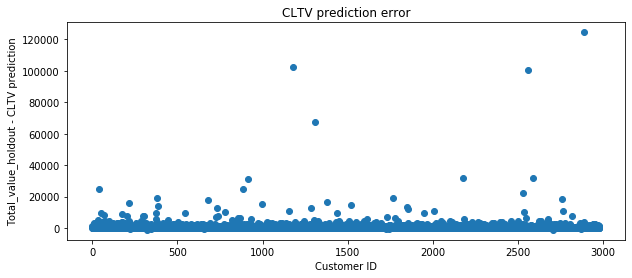

In [49]:
# plot (Total_value_holdout - CLTV prediction) for each customer
# from this graph we can see that overall, our model underestimates the CLTV 
# there are some outliers

pyplot.figure(figsize=(10, 4))
pyplot.scatter(range(0, 2980), CLTV_total_value_holdout['Difference'])
pyplot.xlabel('Customer ID')
pyplot.ylabel('Total_value_holdout - CLTV prediction')
pyplot.title('CLTV prediction error')
pyplot.show()

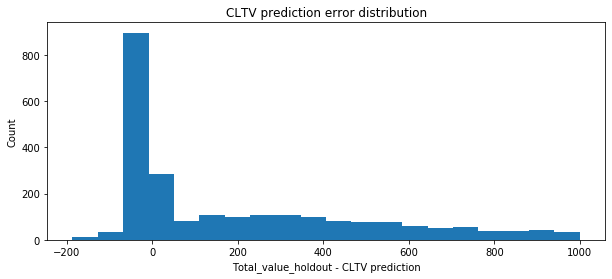

In [50]:
# plot a histogram of prediction error
pyplot.figure(figsize=(10, 4))
pyplot.hist(CLTV_total_value_holdout[(CLTV_total_value_holdout['Difference'] <= 1000) &
                                     (CLTV_total_value_holdout['Difference'] >= -200)]['Difference'], bins=20)
pyplot.xlabel('Total_value_holdout - CLTV prediction')
pyplot.ylabel('Count')
pyplot.title('CLTV prediction error distribution')
pyplot.show()

### visualization/summary of CLTV, explore relationship between frequency/monetary value and CLTV prediction

based on CLTV prediction for the next 12 months

In [51]:
# drop na values
CLTV_1_clean = CLTV_1.dropna()

# describe the data
CLTV_1_clean.describe()

count     2089.000000
mean       203.871302
std        639.543152
min          9.504205
25%         47.726996
50%         83.888101
75%        158.860695
max      14039.908075
Name: clv, dtype: float64

In [52]:
# sum over all CLTV (for the next 12 months period) to evaluate our company?
sum(CLTV_1_clean)

425887.1488380497

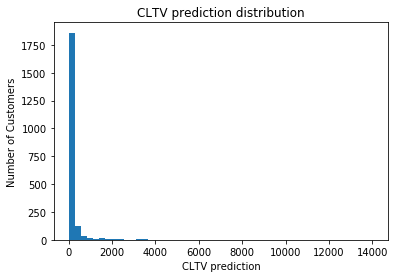

In [53]:
# plot distribution of CLTV

pyplot.hist(CLTV_1_clean, bins = 50)
pyplot.xlabel('CLTV prediction')
pyplot.ylabel('Number of Customers')
pyplot.title('CLTV prediction distribution')
pyplot.show()

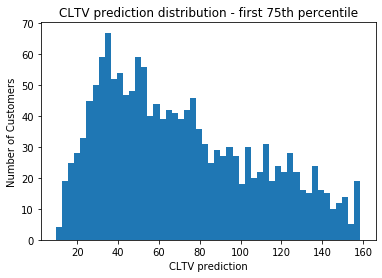

In [54]:
# the first 75th percentile is 158.860695
# zoom in and look at the first 75th percentile
pyplot.hist(CLTV_1_clean.sort_values(na_position="last").head(1566), bins = 50)
pyplot.xlabel('CLTV prediction')
pyplot.ylabel('Number of Customers')
pyplot.title('CLTV prediction distribution - first 75th percentile')
pyplot.show()

In [55]:
# join CLTV table with summary_with_money_value_1 table
summary_with_CLTV = CLTV_1_clean.to_frame()
summary_with_CLTV = summary_with_CLTV.rename(columns = {'clv':'CLTV'})
summary_with_CLTV = summary_with_CLTV.join(summary_with_money_value_1, how = 'left')
summary_with_CLTV.describe()

,CLTV,frequency_cal,recency_cal,T_cal,monetary_value_cal
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,203.871302,4.162757,138.401149,200.777405,30.160722
std,639.543152,5.882252,80.997753,66.661298,67.943346
min,9.504205,1.000000,1.000000,5.000000,0.000000
25%,47.726996,1.000000,71.000000,156.000000,12.359895
50%,83.888101,2.000000,139.000000,216.000000,17.193421
75%,158.860695,5.000000,208.000000,264.000000,24.437188
max,14039.908075,89.000000,273.000000,273.000000,1505.600000


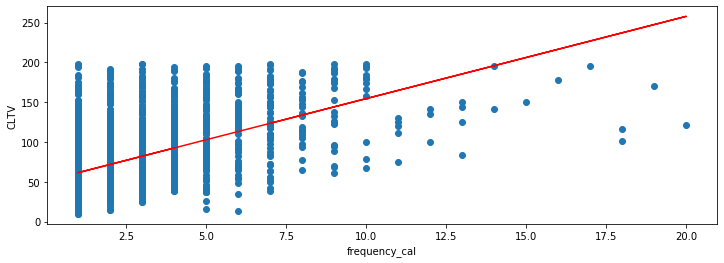

In [56]:
# plot CLTV against frequency and fit a regression line
# let CLTV <= 200 to cut off outliers and make the graph look nicer

f_CLTV = summary_with_CLTV[['frequency_cal', 'CLTV']]
f_CLTV = f_CLTV[(f_CLTV['CLTV'] <= 200) & 
                (f_CLTV['frequency_cal'] <= 20)]

pyplot.figure(figsize=(12, 4))
pyplot.scatter(f_CLTV['frequency_cal'], f_CLTV['CLTV'])

m, b = np.polyfit(f_CLTV['frequency_cal'], f_CLTV['CLTV'], 1)
pyplot.plot(f_CLTV['frequency_cal'], m*f_CLTV['frequency_cal'] + b, color='r')

pyplot.xlabel('frequency_cal')
pyplot.ylabel('CLTV')
pyplot.show()

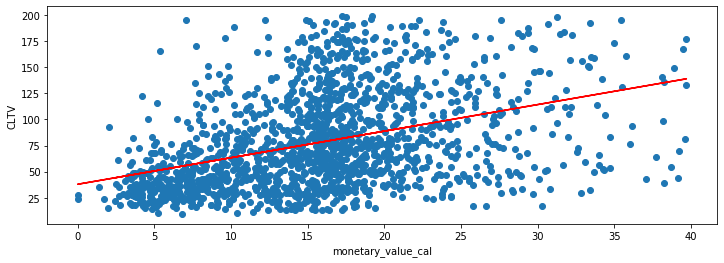

In [57]:
# plot CLTV against monetary_value_cal
# let monetary value <= 40 and CLTV <= 200 to make the graph look nicer

m_CLTV = summary_with_CLTV[['CLTV', 'monetary_value_cal']]
m_CLTV = m_CLTV[(m_CLTV['monetary_value_cal'] <= 40) &
                (m_CLTV['CLTV'] <= 200)]

pyplot.figure(figsize=(12, 4))
pyplot.scatter(m_CLTV['monetary_value_cal'], m_CLTV['CLTV'])

m, b = np.polyfit(m_CLTV['monetary_value_cal'], m_CLTV['CLTV'], 1)
pyplot.plot(m_CLTV['monetary_value_cal'], m*m_CLTV['monetary_value_cal'] + b, color='r')

pyplot.xlabel('monetary_value_cal')
pyplot.ylabel('CLTV')
pyplot.show()

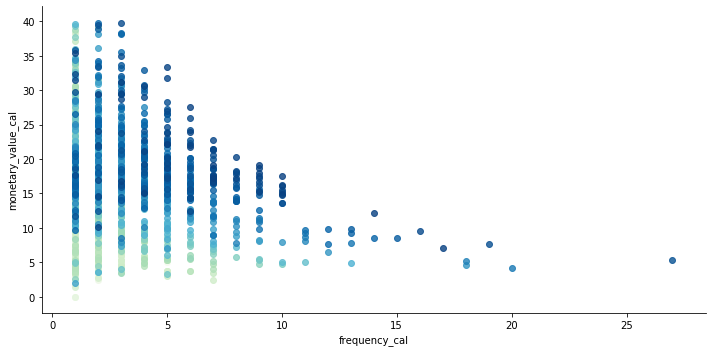

In [58]:
# let monetary value <= 40 and CLTV <= 200 to make the graph look nicer
# x-axis = frequency
# y-axis = monetary value
# the darker the color, the higher the CLTV

f_m_CLTV = summary_with_CLTV[['CLTV', 'monetary_value_cal', 'frequency_cal']]
f_m_CLTV = f_m_CLTV[(f_m_CLTV['CLTV'] <= 200) &
                    (f_m_CLTV['monetary_value_cal'] <= 40)]

sns.lmplot(x='frequency_cal', 
           y='monetary_value_cal', 
           data=f_m_CLTV, 
           fit_reg=False, 
           hue='CLTV', 
           legend=False, 
           palette="GnBu", 
           aspect=2)

###  Show the benefit of targeting "dying" customers with email marketing/coupon

In [59]:
# pull up a sample of customers who:
# latest_within_cal = 2011-08-31
# first_within_cal < 2011-08-31 because our new model will not include customers who joined us on 2011-08-31
# monetary_value_cal > 0 

latest_order_date = '2011-08-31'

sample_1 = cal_hold_df[
            (cal_hold_df["monetary_value_cal"] > 0) &
            (cal_hold_df["latest_within_cal"] == latest_order_date) &
            (cal_hold_df["first_within_cal"] < '2011-08-31')
            ]

sample_1.head()

,total_value_cal,first_within_cal,latest_within_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,,,,,
12381.0,1227.39,2011-08-12,2011-08-31,18.596818,1,19.0,19.0,4,576.57,23.062800,100
12423.0,1650.67,2010-12-21,2011-08-31,15.283981,6,253.0,253.0,2,198.44,11.024444,100
12477.0,8824.48,2011-02-01,2011-08-31,43.257255,4,211.0,211.0,4,4292.53,41.274327,100
12484.0,3626.65,2011-01-07,2011-08-31,12.725088,4,236.0,236.0,3,868.62,13.363385,100
12490.0,2516.77,2011-01-14,2011-08-31,20.461545,4,229.0,229.0,5,2901.16,23.780000,100


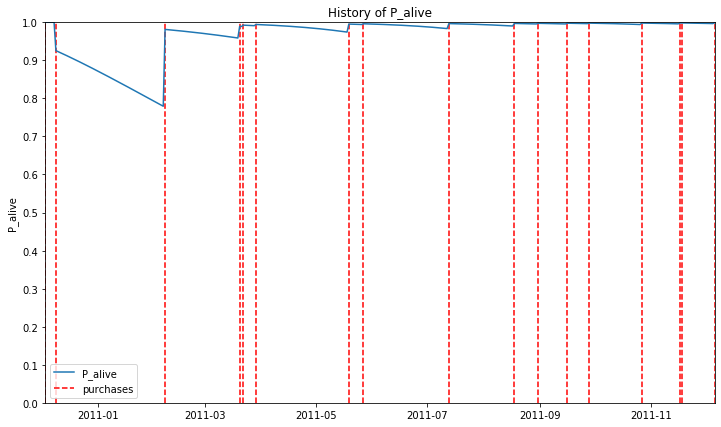

In [60]:
# let's look at the historical probability of being alive of one of these customers

id4 = 18225.0
days_since_birth_4 = 365
sp_trans_4 = tx_keep_date.loc[tx_keep_date['CustomerID'] == id4]

pyplot.figure(figsize=(12, 7))
plot_history_alive(bgf1, days_since_birth_4, sp_trans_4, 'InvoiceDate')
pyplot.show()

In [61]:
# The customers made purchases on 2011-8-31 and the probability of being alive bounced back 
# Let's compare their predicted CLTV on 2011-8-30 and 2011-8-31

# Let's fit the bgf model on data from the beginning to 2011-08-30 
# The new bgf model will have no information on 2011-8-31

end_date_temp = "2011-08-30"
cal_hold_out_temp = cal_holdout(tx_data, cal_end_date = end_date_temp)

bgf_temp = BetaGeoFitter(penalizer_coef=0.01)
bgf_temp.fit(cal_hold_out_temp['frequency_cal'], cal_hold_out_temp['recency_cal'], cal_hold_out_temp['T_cal'])
bgf_temp.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.731984,0.026620,0.679809,0.784159
alpha,49.540003,2.261428,45.107604,53.972402
a,0.024372,0.006753,0.011137,0.037607
b,0.307937,0.075494,0.159969,0.455905


In [62]:
# get data ready for gamma gamma model
returning_customers_summary_temp = cal_hold_out_temp[['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal']]

returning_customers_summary_temp['frequency_cal'] = returning_customers_summary_temp[
    returning_customers_summary_temp['frequency_cal']>0]
returning_customers_summary_temp['monetary_value_cal'] = returning_customers_summary_temp[
    returning_customers_summary_temp['monetary_value_cal']>0]

returning_customers_summary_temp = returning_customers_summary_temp.dropna()

In [63]:
# train Gamma-Gamma submodel

ggf_temp = GammaGammaFitter(penalizer_coef = 0.0)
ggf_temp.fit(returning_customers_summary_temp['frequency_cal'], returning_customers_summary_temp['monetary_value_cal'])
ggf_temp

<lifetimes.GammaGammaFitter: fitted with 2078 subjects, p: 4.78, q: 2.10, v: 1.03>

In [64]:
# CLTV prediction for the next 12 months
CLTV_temp = ggf_temp.customer_lifetime_value(bgf_temp, cal_hold_out_temp['frequency_cal'], 
                                     cal_hold_out_temp['recency_cal'], 
                                     cal_hold_out_temp['T_cal'], 
                                     cal_hold_out_temp['monetary_value_cal'], 
                                     time = 12,  # months
                                     discount_rate = 0.01 # monthly discount rate
                                    )

/Users/daiyangli/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [65]:
# max frequency_cal = 67
# min frequency_cal = 1

sample_1.describe()

,total_value_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.0
mean,10258.112836,49.975359,11.238806,209.835821,209.835821,4.805970,5885.762537,51.877089,100.0
std,24343.145455,104.207695,12.030378,77.860325,77.860325,4.739386,17740.606482,112.918011,0.0
min,64.650000,4.829690,1.000000,5.000000,5.000000,0.000000,0.000000,0.000000,100.0
25%,1408.200000,16.115094,4.000000,171.500000,171.500000,1.000000,357.905000,12.946067,100.0
50%,3249.720000,22.125882,7.000000,253.000000,253.000000,4.000000,1332.790000,23.062800,100.0
75%,8414.580000,33.733598,15.500000,266.000000,266.000000,6.500000,4180.415000,34.776292,100.0
max,175638.940000,703.723158,61.000000,273.000000,273.000000,21.000000,103850.080000,655.584241,100.0


In [66]:
# compare predicted CLTV on 2011-8-30 and predicted CLTV on 2011-8-31

avg_CLTV_increase = np.zeros(61, dtype = float)
frequency_count = np.zeros(61, dtype = int)

for i in sample_1.index: 
    CLTV_before_purchase = round(CLTV_temp.loc[i], 2)
    CLTV_after_purchase = round(CLTV_1.loc[i], 2)
    absolute_value_change = CLTV_after_purchase - CLTV_before_purchase
    percentage_change = absolute_value_change/CLTV_before_purchase
    
    # if not nan
    if (percentage_change == percentage_change):
        f = int(sample_1.loc[i]['frequency_cal'])
        frequency_count[f-1] += 1
        avg_CLTV_increase[f-1] += percentage_change


        
for i in range(len(avg_CLTV_increase)):
    if (avg_CLTV_increase[i]!=0):
        avg_CLTV_increase[i] = avg_CLTV_increase[i]/frequency_count[i]
        

In [76]:
# print outcome

CLTV_increase_frequency = {'frequency_cal' : [i for i in range(1, 62)], 'avg CLTV increase(%)': avg_CLTV_increase*100, 'count': frequency_count}
CLTV_increase_frequency_df = pd.DataFrame(data=CLTV_increase_frequency)
CLTV_increase_frequency_df.head()

,frequency_cal,avg CLTV increase(%),count
0,1,0.000000,0
1,2,103.857926,5
2,3,123.919510,1
3,4,50.920357,9
4,5,25.784189,2


In [68]:
# overall average increase in CLTV(%)
sum(CLTV_increase_frequency_df['avg CLTV increase(%)'] * CLTV_increase_frequency_df['count'])/sum(CLTV_increase_frequency_df['count'])

28.610580370399695

In [69]:
average_CLTV_increase_per_interval = np.zeros(12, dtype=float)

for i in range(0, 12):
    if (i == 11):
        interval = CLTV_increase_frequency_df[5*i < CLTV_increase_frequency_df['frequency_cal']]
    else:   
        interval = CLTV_increase_frequency_df[(5*i < CLTV_increase_frequency_df['frequency_cal']) &
                                   (CLTV_increase_frequency_df['frequency_cal'] <= 5*(i+1))]
    
    if (sum(interval['count']) == 0):
        average_CLTV_increase_per_interval[i] = 0
    else:
        average_CLTV_increase_per_interval[i] = sum(interval['avg CLTV increase(%)']*interval['count'])/sum(interval['count'])

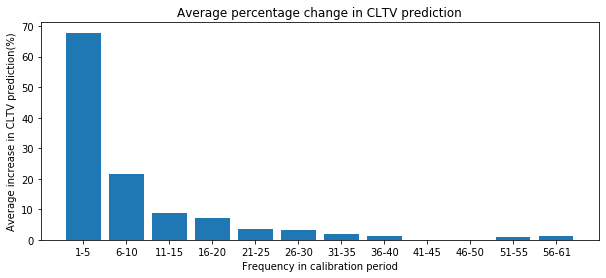

In [70]:
pyplot.figure(figsize=(10, 4))
pyplot.bar(range(0, 12), average_CLTV_increase_per_interval)
pyplot.xlabel('Frequency in calibration period')
pyplot.ylabel('Average increase in CLTV prediction(%)')
pyplot.title('Average percentage change in CLTV prediction')
positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
labels = ("1-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40", "41-45", "46-50", "51-55", "56-61")
pyplot.xticks(positions, labels)
pyplot.show()

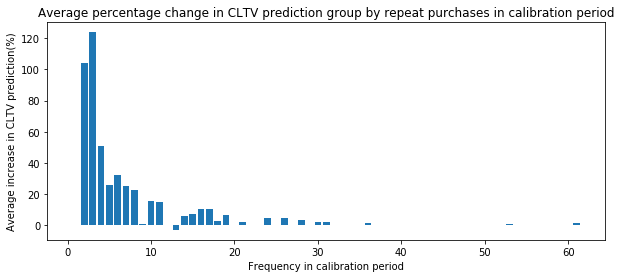

In [71]:
# plot average increase in CLTV for each frequency level

pyplot.figure(figsize=(10, 4))
pyplot.bar(range(1, 62), (avg_CLTV_increase*100))
pyplot.xlabel('Frequency in calibration period')
pyplot.ylabel('Average increase in CLTV prediction(%)')
pyplot.title('Average percentage change in CLTV prediction group by repeat purchases in calibration period')
pyplot.show()

<BarContainer object of 61 artists>

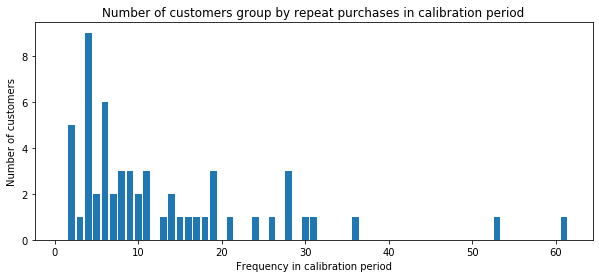

In [72]:
# plot frequency count
# this explains the gaps in the graph above - we don't have customer in all the frequency levels
# shortcoming: small sample size; for many frequency levels, we only have 1 customer

pyplot.figure(figsize=(10, 4))
pyplot.xlabel('Frequency in calibration period')
pyplot.ylabel('Number of customers')
pyplot.title('Number of customers group by repeat purchases in calibration period')
pyplot.bar(range(1, 62), frequency_count)

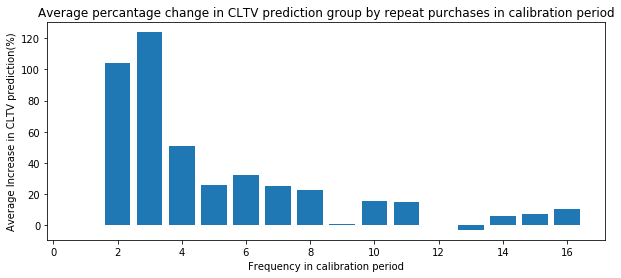

In [73]:
# zoom in to see the first 75%
pyplot.figure(figsize=(10, 4))
pyplot.bar(range(1, 17), (avg_CLTV_increase*100)[0:16])

xlocs = [i for i in range(1, 17)]

pyplot.xlabel('Frequency in calibration period')
pyplot.ylabel('Average Increase in CLTV prediction(%)')
pyplot.title('Average percantage change in CLTV prediction group by repeat purchases in calibration period')
pyplot.show()


In [74]:
# we notice that when frequency = 13, the increase is actually negative - might need to explain why?
# there is only 1 customer that falls into this bin

cal_hold_df[(cal_hold_df["frequency_cal"] == 13) &
            (cal_hold_df["monetary_value_cal"] > 0) &
            (cal_hold_df["latest_within_cal"] == latest_order_date) &
            (cal_hold_df["first_within_cal"] < '2011-08-31')
            ]

,total_value_cal,first_within_cal,latest_within_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,,,,,
15856.0,10019.4,2010-12-09,2011-08-31,23.246868,13,265.0,265.0,7,6154.27,27.721937,100


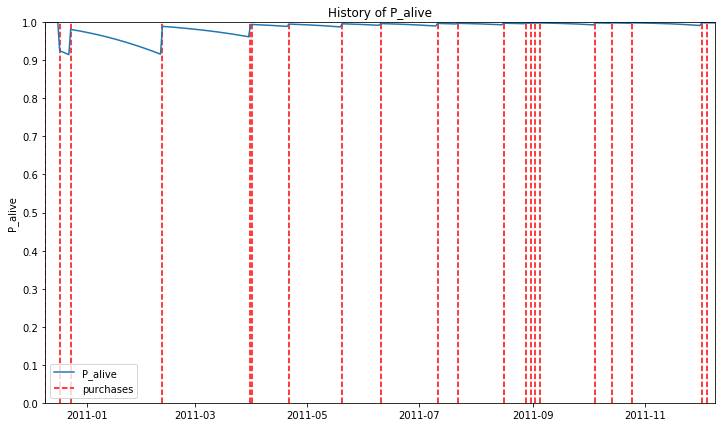

In [75]:
# let's look at the historical p_alive of this customer 15856.0

days_since_birth_5 = 365
sp_trans_5 = tx_keep_date.loc[tx_keep_date['CustomerID'] == 15856.0]

pyplot.figure(figsize=(12, 7))
plot_history_alive(bgf1, days_since_birth_5, sp_trans_5, 'InvoiceDate')
pyplot.show()